In [2]:
## Tensorflow Keras and rest of the packagesn
import keras as k
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
#import tensorflow.keras as k2 ,
from keras.layers import Dense,Input
from keras.optimizers import Adam, RMSprop
from keras.models import load_model, save_model
from keras.saving import register_keras_serializable
import numpy as np
import cmath
import math
from tensorflow import keras
import time
import pandas as pd

# Cosas plots

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.ticker as ticker
plt.style.use('tableau-colorblind10')


cud_colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

# Condiciones iniciales

In [4]:
A=8.0/100        #it represents the factor 2GM/c^2,
GM_c2= A/2   #it represents the factor GM/c^2,
x0_rk = -1; x_ini= -1
y0_rk = 0.35; y_ini=0.35 
vx0_rk=1/(1.0/(1.0-A/np.sqrt(x0_rk**2+y0_rk**2)))   ; vx_ini=1/(1.0/(1.0-A/np.sqrt(x0_rk**2+y0_rk**2))) 
vy0_rk = 0.0  ; vy_ini=0.0

# Creamos la PINN

In [4]:
@register_keras_serializable()
@keras.saving.register_keras_serializable()
class ODE_2nd(tf.keras.Model):
    def set_ODE_param(self,z0,x0,dx_dz0,A, auxx, aux2):
        '''
        Set parameters and initial conditions for the ODE
        '''
        self.z0=tf.constant([z0], dtype=tf.float32)
        self.x0_true=tf.constant(x0, dtype=tf.float32)
        self.dx_dz0_true=tf.constant(dx_dz0, dtype=tf.float32)
        self.A=tf.constant(A,dtype=tf.float32)
        self.auxx=tf.constant(auxx,dtype=tf.float32)
        self.aux2=tf.constant(aux2,dtype=tf.float32)

    def train_step(self, data):
        '''
        Training ocurrs here
        '''
        z, x_true = data
        with tf.GradientTape() as tape:
            #* Initial conditions
            tape.watch(self.z0)
            tape.watch(self.x0_true)
            tape.watch(self.dx_dz0_true)
            tape.watch(self.A)
            tape.watch(z)

            with tf.GradientTape() as tape0:
                    tape0.watch(self.z0)
                    x0_pred= self(self.z0,training=False)
                    tape0.watch(x0_pred)

            with tf.GradientTape() as tape1:
                tape1.watch(z)
                x=self(z,training=False)
                tape1.watch(x)
            dx_dz=tape1.jacobian(x,z)
            dx_dz=tf.squeeze(dx_dz)
            dx_dz=tf.reshape(dx_dz,shape=x.shape)
            tape.watch(z)
            tape.watch(x)
            tape.watch(dx_dz)

 
            #* Definition of r and n
            r=tf.math.sqrt(x[:,0]**2+x[:,1]**2)
            n=1.0/(1.0-self.A/r)
            aux=[0.0,0.0,0.0,0.0]
            aux=tf.reshape(aux,shape=x.shape)
  

            #? Original ODE's order
            '''
            lossODE= self.compiled_loss(dx_dz[:,0],x[:,2]/n)\
                    +self.compiled_loss(dx_dz[:,1],x[:,3]/n)\
                    +self.compiled_loss(dx_dz[:,2],-self.A*tf.math.pow(n,2)*x[:,0]/tf.math.pow(r,3))\
                    +self.compiled_loss(dx_dz[:,3],-self.A*tf.math.pow(n,2)*x[:,1]/tf.math.pow(r,3))

            '''
            '''
            #? Alternative ODE's order (1)
            lossODE= self.compiled_loss(n*dx_dz[:,0],x[:,2])\
                    +self.compiled_loss(n*dx_dz[:,1],x[:,3])\
                    +self.compiled_loss(tf.math.pow(r,3)*dx_dz[:,2]/tf.math.pow(n,2),-self.A*x[:,0])\
                    +self.compiled_loss(tf.math.pow(r,3)*dx_dz[:,3]/tf.math.pow(n,2),-self.A*x[:,1])
                    #+self.compiled_loss(A/tf.math.pow((x[:,0]*x[:,0]+x[:,1]*x[:,1]),0.5),aux[:,0])

            '''
            
            #? Alternative ODE's order (2)
            lossODE= self.compiled_loss(dx_dz[:,0],x[:,2]/n)\
                    +self.compiled_loss(dx_dz[:,1],x[:,3]/n)\
                    +self.compiled_loss(tf.math.pow(r,3)*dx_dz[:,2],-self.A*tf.math.pow(n,2)*x[:,0])*5\
                    +self.compiled_loss(tf.math.pow(r,3)*dx_dz[:,3],-self.A*tf.math.pow(n,2)*x[:,1])*10
                


            #* initial condition loss
            lossODE= lossODE\
                  + self.compiled_loss(x0_pred,self.x0_true) \
                  
            #* "Chinchetas" loss
            aux_pred=self(self.aux2, training=False)
            loss=lossODE\
                +self.compiled_loss(self.auxx,aux_pred)*5


        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(x_true, x)
        metrics={m.name: m.result() for m in self.metrics}
        metrics.pop('mean_squared_error')
        metrics['z']=z
        metrics['x0']=x0_pred[:,0]
        metrics['y0']=x0_pred[:,1]
        metrics['vx0']=x0_pred[:,2]
        metrics['vy0']=x0_pred[:,3]
        metrics['x']=x[:,0]
        metrics['y']=x[:,1]
        metrics['vx']=x[:,2]
        metrics['vy']=x[:,3]
        metrics['n'] = n
        metrics['r'] = r
        print(self.A)
        return metrics

In [5]:
#* Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 4


#* Define the model
initializer = tf.keras.initializers.GlorotUniform(seed=5)
activation='tanh'
input=Input(shape=(input_neurons,))
x=Dense(500, activation=activation,kernel_initializer=initializer)(input)
x=Dense(500, activation=activation,kernel_initializer=initializer)(x)
x=Dense(500, activation=activation,kernel_initializer=initializer)(x)
x=Dense(500, activation=activation,kernel_initializer=initializer)(x)
x=Dense(500, activation=activation,kernel_initializer=initializer)(x)
output = Dense(output_neurons,kernel_initializer=initializer,activation=None)(x)

#* Build the modeln
model=ODE_2nd(input,output)

# Cargar los pesos

In [6]:
zmin=0
zmax=2
N_intervalo=6
sim=2
model.load_weights(f"modelos_agujero_negro/pesos_inter={N_intervalo}_y={y_ini}_N=200_sim={sim}.h5")

z_red=np.linspace(zmin,zmax,40)
z_red=np.reshape(z_red,(40,1))
xy_pred=model.predict(z_red)

2/2 [==============================] - 0s 0s/step


# RK

In [7]:
def f_x(t, x, y, vx, vy):
    #* vx's ODE
    return vx/n_xy(x,y)

def f_y(t, x, y, vx, vy):
    #* vy's ODE
    return vy/n_xy(x, y)

def g_x(t, x, y, vx, vy):
    #* ax's ODE
    return -n_xy(x,y)**2*2*GM_c2*x/((x**2+y**2+epsilon2**2)**(3/2))

def g_y(t, x, y, vx, vy):
    #* ay's ODE
    return -n_xy(x,y)**2*2*GM_c2*y/((x**2+y**2+epsilon2**2)**(3/2))

def n_xy(x, y):
    #*Ecuación que calcula el índice de refracción
    return (1/(1-(2*GM_c2/(x**2+y**2+epsilon2**2)**0.5)))

#* fourth order runge kutta
def runge_kutta_4th_order(t, x, y, vx, vy, h):

    k1_x = h * f_x(t, x, y, vx, vy)
    k1_y = h * f_y(t, x, y, vx, vy)
    k1_vx = h * g_x(t, x, y, vx, vy)
    k1_vy = h * g_y(t, x, y, vx, vy)

    k2_x = h * f_x(t + 0.5 * h, x + 0.5 * k1_x, y + 0.5 * k1_y, vx + 0.5 * k1_vx, vy + 0.5 * k1_vy)
    k2_y = h * f_y(t + 0.5 * h, x + 0.5 * k1_x, y + 0.5 * k1_y, vx + 0.5 * k1_vx, vy + 0.5 * k1_vy)
    k2_vx = h * g_x(t + 0.5 * h, x + 0.5 * k1_x, y + 0.5 * k1_y, vx + 0.5 * k1_vx, vy + 0.5 * k1_vy)
    k2_vy = h * g_y(t + 0.5 * h, x + 0.5 * k1_x, y + 0.5 * k1_y, vx + 0.5 * k1_vx, vy + 0.5 * k1_vy)

    k3_x = h * f_x(t + 0.5 * h, x + 0.5 * k2_x, y + 0.5 * k2_y, vx + 0.5 * k2_vx, vy + 0.5 * k2_vy)
    k3_y = h * f_y(t + 0.5 * h, x + 0.5 * k2_x, y + 0.5 * k2_y, vx + 0.5 * k2_vx, vy + 0.5 * k2_vy)
    k3_vx = h * g_x(t + 0.5 * h, x + 0.5 * k2_x, y + 0.5 * k2_y, vx + 0.5 * k2_vx, vy + 0.5 * k2_vy)
    k3_vy = h * g_y(t + 0.5 * h, x + 0.5 * k2_x, y + 0.5 * k2_y, vx + 0.5 * k2_vx, vy + 0.5 * k2_vy)

    k4_x = h * f_x(t + h, x + k3_x, y + k3_y, vx + k3_vx, vy + k3_vy)
    k4_y = h * f_y(t + h, x + k3_x, y + k3_y, vx + k3_vx, vy + k3_vy)
    k4_vx = h * g_x(t + h, x + k3_x, y + k3_y, vx + k3_vx, vy + k3_vy)
    k4_vy = h * g_y(t + h, x + k3_x, y + k3_y, vx + k3_vx, vy + k3_vy)

    new_x = x + (1/6) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
    new_y = y + (1/6) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    new_vx = vx + (1/6) * (k1_vx + 2 * k2_vx + 2 * k3_vx + k4_vx)
    new_vy = vy + (1/6) * (k1_vy + 2 * k2_vy + 2 * k3_vy + k4_vy)

    return new_x, new_y, new_vx, new_vy

In [8]:
#* RK's initial conditions

t0 = 0.0
tfin=2
h = 0.01  # time step
pasos= int((tfin-t0)/h)
epsilon=0.1
epsilon2=0

x_tot=[]
y_tot=[]
vx_tot=[]
vy_tot=[]
t_tot=[]

x_tot.append(x0_rk)
y_tot.append(y0_rk)
vx_tot.append(vx0_rk)
vy_tot.append(vy0_rk)
t_tot.append(t0)


x_rk=x0_rk; y_rk=y0_rk; vx_rk=vx0_rk; vy_rk=vy0_rk
for i in range(pasos):
    x_rk, y_rk, vx_rk, vy_rk = runge_kutta_4th_order(t0, x_rk, y_rk, vx_rk, vy_rk, h)
    if (((x_rk**2+y_rk**2)**0.5)<A+0.001):

        break
    x_tot.append(x_rk)
    y_tot.append(y_rk)
    vx_tot.append(vx_rk)
    vy_tot.append(vy_rk)
    t0 += h
    t_tot.append(t0)

# Cargar chinchetas

In [35]:
aux2=[]
chinchetas_x=[]
chinchetas_y=[]
chinchetas_vx=[]
chinchetas_vy=[]

ruta_chinchetas = f'multiple_agujero_negro/chinchetas_y0={y_ini}_Ninter={N_intervalo}_rep={sim}.txt'
with open(ruta_chinchetas, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        aux2.append(float(valores[0]))
        chinchetas_x.append(float(valores[1]))
        chinchetas_y.append(float(valores[2]))
        chinchetas_vx.append(float(valores[3]))
        chinchetas_vy.append(float(valores[4]))

# Plots


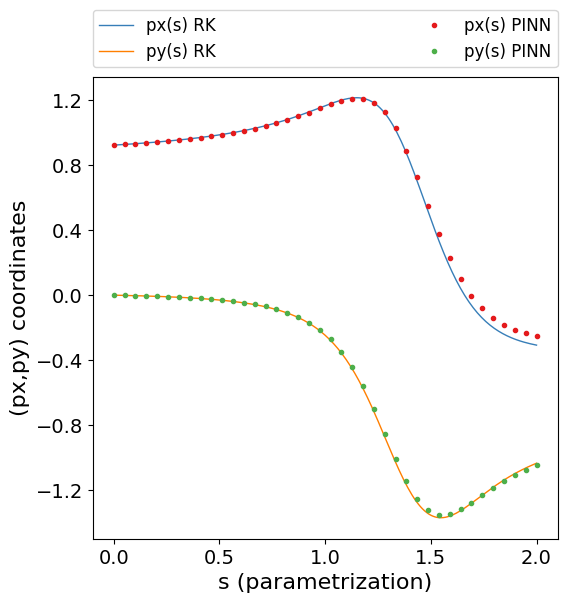

In [36]:
#chinchetas=np.array(auxx)

fig, ax = plt.subplots(dpi=100)
#* RK
ax.plot(t_tot, vx_tot, linestyle='-', linewidth=1,color=cud_colors[0], label='px(s) RK')
ax.plot(t_tot, vy_tot, linestyle='-', linewidth=1,color=cud_colors[1], label='py(s) RK')

#* PINN
ax.plot(z_red, xy_pred[:,2], color=cud_colors[7],marker='o',markersize=3.0, linestyle='solid', linewidth=0, label="px(s) PINN")
ax.plot(z_red, xy_pred[:,3], color=cud_colors[2],marker='o',markersize=3.0, linestyle='solid', linewidth=0, label="py(s) PINN")

#*"Chinchetas"
#ax.plot(aux2, chinchetas_vx, "o", markersize=6, color=cud_colors[0], label='chinchetas px')
#ax.plot(aux2, chinchetas_vy, "o", markersize=6, color=cud_colors[1], label='chinchetas py')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel('s (parametrization)', fontsize=16)
ax.set_ylabel('(px,py) coordinates', fontsize=16)

#* Adds a legend
ax.legend()

ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(8))

plt.grid(False)  # Optional
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)

fig.set_size_inches(6,6)
#?Save the plot
#fig.savefig(f'figuras definitivas/Black_hole_velocity_chinchetas={N_intervalos}_y={y_ini}_N={N_train_max}_.png',bbox_inches='tight', dpi=600)

plt.show()

In [37]:
auxx=np.zeros((10, 4))
ayuda=np.arange(4)
auxx[0]=ayuda
print(auxx[0])

[0. 1. 2. 3.]


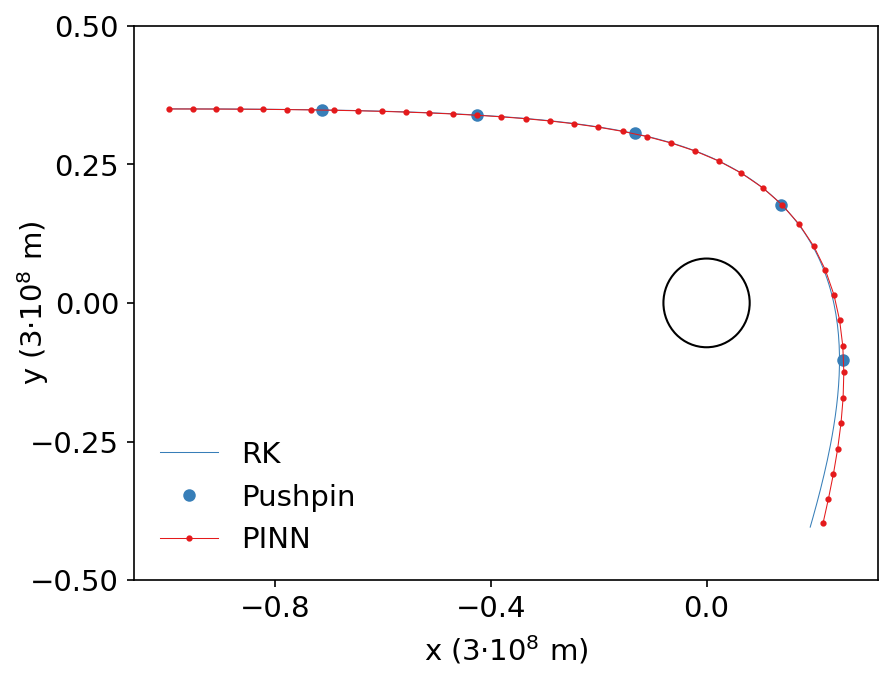

In [38]:
fig, ax = plt.subplots(dpi=150)
#* RK
ax.plot(x_tot, y_tot, linestyle='-', linewidth=0.5,color=cud_colors[0], label='RK')

#* Chinchetas
ax.plot(chinchetas_x, chinchetas_y, "o", markersize=5, color=cud_colors[0], label='Pushpin')

#* PINN
ax.plot(xy_pred[:,0], xy_pred[:,1], color=cud_colors[7],marker='o',markersize=2.0, linestyle='solid', linewidth=0.5, label="PINN")

ax.tick_params(axis='both', which='major', labelsize=14)


#* Adds the horizont event circle
circle = Circle((0, 0), A, fill=False, color='black', linestyle='-')
#circle = Circle((0, 0), A*3*10**8, fill=False, color='black', linestyle='-')
ax.add_patch(circle)

ax.set_xlabel('x (3·$10^8$ m)',labelpad=5, fontsize=14)
ax.set_ylabel('y (3·$10^8$ m)',labelpad=-10, fontsize=14)

#* Add legend
ax.legend(fontsize=14, frameon=False)

#* Show grafic
#plt.gca().set_aspect('equal', adjustable='box')
ax.set_ylim(-0.5,0.5)
plt.grid(False)  # Optional

ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

#plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.2))

#plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                #mode="expand", borderaxespad=0, ncol=2,fontsize=12)

#? Save the plot
plt.savefig(f'figuras definitivas/Black_hole_trajectorie_chinchetas.pdf',bbox_inches='tight', dpi=800)
#plt.tight_layout()
plt.show()

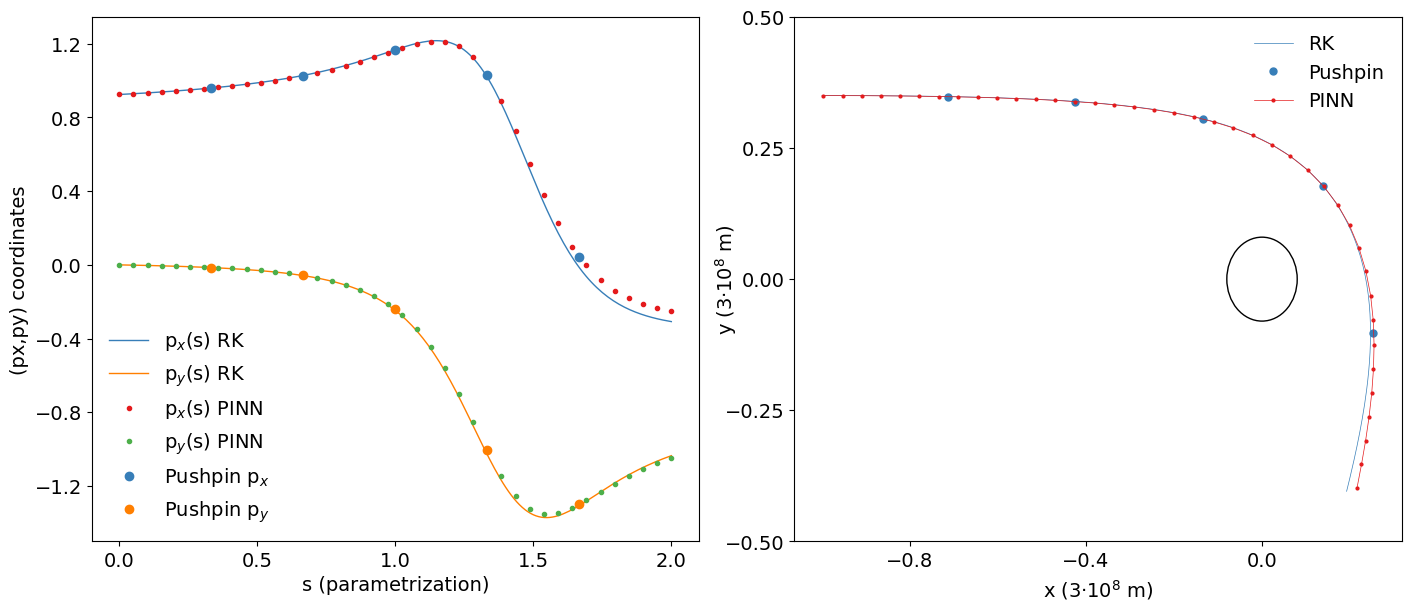

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), layout='constrained')

ax[0].tick_params(axis='both', which='major', labelsize=14)

ax[0].plot(t_tot, vx_tot, linestyle='-', linewidth=1,color=cud_colors[0], label='p$_x$(s) RK')
ax[0].plot(t_tot, vy_tot, linestyle='-', linewidth=1,color=cud_colors[1], label='p$_y$(s) RK')

#* PINN
ax[0].plot(z_red, xy_pred[:,2], color=cud_colors[7],marker='o',markersize=3.0, linestyle='solid', linewidth=0, label=f"p$_x$(s) PINN")
ax[0].plot(z_red, xy_pred[:,3], color=cud_colors[2],marker='o',markersize=3.0, linestyle='solid', linewidth=0, label=f"p$_y$(s) PINN")

#*"Chinchetas"
ax[0].plot(aux2, chinchetas_vx, "o", markersize=6, color=cud_colors[0], label='Pushpin p$_x$')
ax[0].plot(aux2, chinchetas_vy, "o", markersize=6, color=cud_colors[1], label='Pushpin p$_y$')


ax[0].set_xlabel('s (parametrization)', fontsize=14)
ax[0].set_ylabel('(px,py) coordinates', fontsize=14)

#* Adds a legend
ax[0].legend(fontsize=14, frameon=False)

ax[0].xaxis.set_major_locator(ticker.MaxNLocator(5))
ax[0].yaxis.set_major_locator(ticker.MaxNLocator(8))

plt.grid(False)  # Optional
#plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                #mode="expand", borderaxespad=0, ncol=2,fontsize=12)

#?Save the plot
#fig.savefig(f'figuras definitivas/Black_hole_velocity_chinchetas={N_intervalos}_y={y_ini}_N={N_train_max}_.png',bbox_inches='tight', dpi=600)


#* RK
ax[1].plot(x_tot, y_tot, linestyle='-', linewidth=0.5,color=cud_colors[0], label='RK')

#* Chinchetas
ax[1].plot(chinchetas_x, chinchetas_y, "o", markersize=5, color=cud_colors[0], label='Pushpin')

#* PINN
ax[1].plot(xy_pred[:,0], xy_pred[:,1], color=cud_colors[7],marker='o',markersize=2.0, linestyle='solid', linewidth=0.5, label="PINN")

ax[1].tick_params(axis='both', which='major', labelsize=14)


#* Adds the horizont event circle
circle = Circle((0, 0), A, fill=False, color='black', linestyle='-')
#circle = Circle((0, 0), A*3*10**8, fill=False, color='black', linestyle='-')
ax[1].add_patch(circle)

ax[1].set_xlabel('x (3·$10^8$ m)',labelpad=5, fontsize=14)
ax[1].set_ylabel('y (3·$10^8$ m)',labelpad=-10, fontsize=14)

#* Add legend
ax[1].legend(fontsize=14, frameon=False)

#* Show grafic
#plt.gca().set_aspect('equal', adjustable='box')
ax[1].set_ylim(-0.5,0.5)
plt.grid(False)  # Optional

ax[1].xaxis.set_major_locator(ticker.MaxNLocator(4))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(4))

#plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.2))

#plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                #mode="expand", borderaxespad=0, ncol=2,fontsize=12)

#? Save the plot
#plt.savefig(f'figuras definitivas/Black_hole_trajectorie_chinchetas={N_intervalos}_y={y_ini}_N={N_train_max}_.png',bbox_inches='tight', dpi=600)
#plt.tight_layout()
plt.show()

# Estadistica

In [5]:
n_chinchetas=[0,1,2,3,4,5]
n_chinchetas_pesos=[1,2,3,4,5]
error=[]
error_pesos=[]
error.append([])
for i in range (len(n_chinchetas)-1):
    error.append([])
    error_pesos.append([])
print(error)



ruta = 'multiple_agujero_negro/error_chinchetas_y0.35.txt'
with open(ruta, 'r') as archivo:
    for linea in archivo:
        j=0
        valores = linea.split()
        for i in (n_chinchetas):
            if (i==int(valores[0])):
                error[j].append(float(valores[2]))
            j=j+1


ruta1 = 'multiple_agujero_negro/error_chinchetas_y0.35_pesos.txt'
with open(ruta1, 'r') as archivo:
    for linea in archivo:
        j=0
        valores = linea.split()
        for i in (n_chinchetas):
            if (i==int(valores[0])):
                error_pesos[j-1].append(float(valores[2]))
            j=j+1

[[], [], [], [], [], []]


In [6]:
#for i in error[0]:
    #error[3].append(0)
    #error[5].append(0)
#print(error)

# for i in error[0]:
#     #error_pesos[1].append(0)
#     error_pesos[2].append(0)
#     error_pesos[3].append(0)
#     error_pesos[4].append(0)
# print(error_pesos)

In [7]:
media=[]
media_pesos=[]
desviacion=[]
desviacion_pesos=[]
error=np.array(error)
error_pesos=np.array(error_pesos)
n_filas=np.size(error[:,0])
N=np.size(error[0])

for i in range(n_filas):
    sum=0
    for j in (error[i]):
        sum=sum+j
    media.append(sum/N)
    

for i in range(n_filas-1):
    sum_pesos=0
    for k in (error_pesos[i]):
        sum_pesos=sum_pesos+k
    media_pesos.append(sum_pesos/N)

for i in range (n_filas):
    sum=0
    sum_pesos=0
    for j in error[i]:
        sum=sum+(j-media[i])**2
    desviacion.append(np.sqrt(sum/N))


for i in range (n_filas-1):
    sum_pesos=0
    for k in error_pesos[i]:
        sum_pesos=sum_pesos+(k-media_pesos[i])**2
    desviacion_pesos.append(np.sqrt(sum_pesos/N))
    
print(media)
print(desviacion)
print(media_pesos)
print(desviacion_pesos)

[9.526454949427158, 5.500931283104803, 2.1446564044118817, 0.7451083500725295, 0.9142865342828932, 0.45201426240982345]
[2.677179700821178, 0.9265349796604165, 2.028105588061635, 0.44008717581449536, 0.4439052343245824, 0.2961903494413591]
[10.203235561253903, 6.580874582070133, 5.286250710492711, 3.877208171190529, 2.891581171997017]
[2.422806843165469, 3.187816869204127, 2.9833365557025777, 2.7459462160995347, 1.8616453077299138]


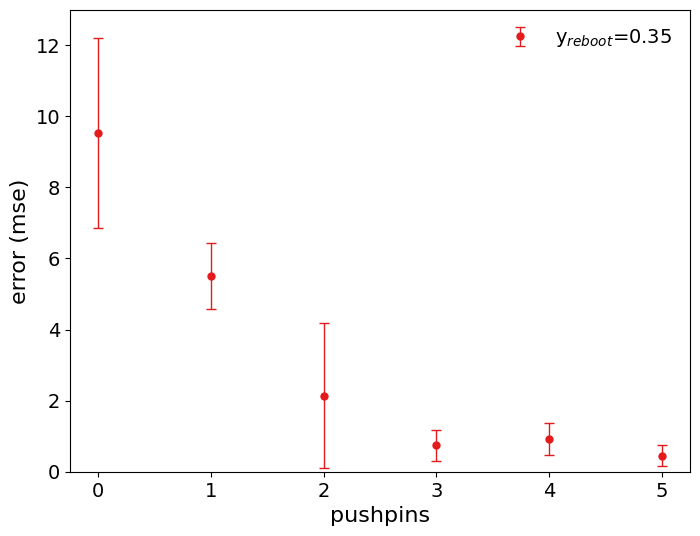

In [8]:
fig, ax = plt.subplots(dpi=100)
#* RK
#ax.errorbar(n_chinchetas_pesos, media_pesos, yerr=desviacion_pesos, color=cud_colors[0], ecolor=cud_colors[0],elinewidth=1 ,marker='o',markersize=5.0, capsize=3.5, capthick=1, linestyle='solid', linewidth=0, label=r"y=0.35")
ax.errorbar(n_chinchetas, media, yerr=desviacion,  color=cud_colors[7], ecolor=cud_colors[7],elinewidth=1 ,marker='o',markersize=5.0, capsize=3.5, capthick=1, linestyle='solid', linewidth=0, label=r"y$_{reboot}$=0.35")
#ax.plot(plot_chincheta, plot_error_040, color="orange",marker='o',markersize=5.0, linestyle='solid', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel('pushpins', fontsize=16)
ax.set_ylabel('error (mse)', fontsize=16)

ax.legend(fontsize=14, frameon=False)

#* Show grafic
#plt.gca().set_aspect('equal', adjustable='box')

plt.grid(False)  # Optional
ax.set_ylim([0,13])

plt.savefig(f'figuras definitivas/pushpins_error.pdf',bbox_inches='tight', dpi=800)

fig.set_size_inches(8,6)